In [2]:
import pandas as pd 
import numpy as np
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
import shap
from sklearn.model_selection import train_test_split


/Users/sanzhar/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("eskin_clusters-2.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222744 entries, 0 to 222743
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   sex                     222744 non-null  int64
 1   spanish                 222744 non-null  int64
 2   mobility_issue          222744 non-null  int64
 3   main_activity_group     222744 non-null  int64
 4   prof_status_group       222744 non-null  int64
 5   driving_license_binary  222744 non-null  int64
 6   educ_group              222744 non-null  int64
 7   transport_card_binary   222744 non-null  int64
 8   age_group               222744 non-null  int64
 9   electric.               222744 non-null  int64
 10  private_parking.        222744 non-null  int64
 11  pp_4age_hh              222744 non-null  int64
 12  vehicles_hh             222744 non-null  int64
 13  trips_hh                222744 non-null  int64
 14  ppl_hh                  222744 non-null  int64
 15  

In [5]:
y = df["cluster_labels_k_5"]
X = df.drop(columns=["cluster_labels_k_2", "cluster_labels_k_3", "cluster_labels_k_4", "cluster_labels_k_5", "cluster_labels_k_6", "cluster_labels_k_7", "cluster_labels_k_8", "cluster_labels_k_9"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [6]:
# Shuffle the data first (optional)
df_shuffled = df.sample(frac=1, random_state=42)

# Manual 80/20 split
train_size = int(0.8 * len(df))
train_df = df_shuffled[:train_size]
test_df = df_shuffled[train_size:]

X_train = train_df.drop(columns=["cluster_labels_k_2", "cluster_labels_k_3", "cluster_labels_k_4", "cluster_labels_k_5", "cluster_labels_k_6", "cluster_labels_k_7", "cluster_labels_k_8", "cluster_labels_k_9"])
y_train = train_df["cluster_labels_k_5"]
X_test = test_df.drop(columns=["cluster_labels_k_2", "cluster_labels_k_3", "cluster_labels_k_4", "cluster_labels_k_5", "cluster_labels_k_6", "cluster_labels_k_7", "cluster_labels_k_8", "cluster_labels_k_9"])
y_test = test_df["cluster_labels_k_5"]

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178195 entries, 28235 to 118366
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   sex                     178195 non-null  int64
 1   spanish                 178195 non-null  int64
 2   mobility_issue          178195 non-null  int64
 3   main_activity_group     178195 non-null  int64
 4   prof_status_group       178195 non-null  int64
 5   driving_license_binary  178195 non-null  int64
 6   educ_group              178195 non-null  int64
 7   transport_card_binary   178195 non-null  int64
 8   age_group               178195 non-null  int64
 9   electric.               178195 non-null  int64
 10  private_parking.        178195 non-null  int64
 11  pp_4age_hh              178195 non-null  int64
 12  vehicles_hh             178195 non-null  int64
 13  trips_hh                178195 non-null  int64
 14  ppl_hh                  178195 non-null  int64
dtypes

In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66824 entries, 28235 to 196100
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   sex                     66824 non-null  int64
 1   spanish                 66824 non-null  int64
 2   mobility_issue          66824 non-null  int64
 3   main_activity_group     66824 non-null  int64
 4   prof_status_group       66824 non-null  int64
 5   driving_license_binary  66824 non-null  int64
 6   educ_group              66824 non-null  int64
 7   transport_card_binary   66824 non-null  int64
 8   age_group               66824 non-null  int64
 9   electric.               66824 non-null  int64
 10  private_parking.        66824 non-null  int64
 11  pp_4age_hh              66824 non-null  int64
 12  vehicles_hh             66824 non-null  int64
 13  trips_hh                66824 non-null  int64
 14  ppl_hh                  66824 non-null  int64
dtypes: int64(15)
memory

In [8]:
combined = pd.concat([X_train, X_test])
duplicate_rows = combined.duplicated(keep=False)
identical = combined[duplicate_rows]

# Each identical row appears twice, so divide by 2
print(f"Number of identical rows: {len(identical) // 2}")

Number of identical rows: 110753


In [9]:
# Objective function for Optuna
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    clf = LGBMClassifier(**params, random_state = 42)
    score = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=5).mean()
    return score


In [10]:
# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f'Best trial: {study.best_trial.value}')
print(f'Best params: {study.best_trial.params}')

[I 2025-04-11 18:48:24,778] A new study created in memory with name: no-name-87ec058c-c8b7-4bdf-a7c2-202283e4fea6


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:48:46,295] Trial 0 finished with value: 0.9999494920238107 and parameters: {'num_leaves': 37, 'max_depth': 7, 'learning_rate': 0.26126805604844355, 'n_estimators': 257, 'colsample_bytree': 0.611800664725372, 'subsample': 0.6181556251349655, 'reg_alpha': 0.5372069410976756, 'reg_lambda': 0.35869795249651737}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:48:57,468] Trial 1 finished with value: 0.9998709269557645 and parameters: {'num_leaves': 110, 'max_depth': 15, 'learning_rate': 0.09924627275341821, 'n_estimators': 73, 'colsample_bytree': 0.7845915881741041, 'subsample': 0.686203337752304, 'reg_alpha': 0.4530238710682196, 'reg_lambda': 0.9296294800039863}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:49:16,124] Trial 2 finished with value: 0.9999270449789261 and parameters: {'num_leaves': 36, 'max_depth': 7, 'learning_rate': 0.08985025646617918, 'n_estimators': 204, 'colsample_bytree': 0.9019024759397356, 'subsample': 0.990330776753167, 'reg_alpha': 0.7721849467007224, 'reg_lambda': 0.39054053422641877}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:49:24,809] Trial 3 finished with value: 0.9999270444770911 and parameters: {'num_leaves': 42, 'max_depth': 5, 'learning_rate': 0.17424513419700705, 'n_estimators': 102, 'colsample_bytree': 0.9111289279285751, 'subsample': 0.8991549541305712, 'reg_alpha': 0.9941557994253043, 'reg_lambda': 0.9763769970955345}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:49:36,342] Trial 4 finished with value: 0.9999270449789261 and parameters: {'num_leaves': 33, 'max_depth': 11, 'learning_rate': 0.22576963571190162, 'n_estimators': 166, 'colsample_bytree': 0.8397907573222537, 'subsample': 0.9877693133993664, 'reg_alpha': 0.7995060219046252, 'reg_lambda': 0.3118250343679918}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-11 18:49:55,846] Trial 5 finished with value: 0.9999494920238107 and parameters: {'num_leaves': 97, 'max_depth': 8, 'learning_rate': 0.2810331352275506, 'n_estimators': 224, 'colsample_bytree': 0.6144946855147395, 'subsample': 0.9872640410084658, 'reg_alpha': 0.5125308769832987, 'reg_lambda': 0.8004576254429805}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:50:13,803] Trial 6 finished with value: 0.9999494920238107 and parameters: {'num_leaves': 39, 'max_depth': 4, 'learning_rate': 0.11199888601620914, 'n_estimators': 249, 'colsample_bytree': 0.8976091847676475, 'subsample': 0.6678454903759203, 'reg_alpha': 0.4082040336554954, 'reg_lambda': 0.4898413538592399}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:50:26,873] Trial 7 finished with value: 0.9999438802525049 and parameters: {'num_leaves': 111, 'max_depth': 3, 'learning_rate': 0.1998878544451577, 'n_estimators': 230, 'colsample_bytree': 0.9955665746007472, 'subsample': 0.9387165252342502, 'reg_alpha': 0.34717504002467947, 'reg_lambda': 0.634290221852993}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:50:37,942] Trial 8 finished with value: 0.9999438801355508 and parameters: {'num_leaves': 130, 'max_depth': 6, 'learning_rate': 0.1195826125269683, 'n_estimators': 100, 'colsample_bytree': 0.7432997910839839, 'subsample': 0.6792911982533901, 'reg_alpha': 0.2316620390076144, 'reg_lambda': 0.8400820903070512}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:50:52,639] Trial 9 finished with value: 0.9999494920238107 and parameters: {'num_leaves': 46, 'max_depth': 6, 'learning_rate': 0.2175923722752844, 'n_estimators': 164, 'colsample_bytree': 0.6940234505622072, 'subsample': 0.9279933735292564, 'reg_alpha': 0.5418687848835115, 'reg_lambda': 0.5521665709012751}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:52:03,247] Trial 10 finished with value: 0.9997923606016121 and parameters: {'num_leaves': 65, 'max_depth': 11, 'learning_rate': 0.015988196714802283, 'n_estimators': 297, 'colsample_bytree': 0.6067921211569977, 'subsample': 0.787779887428943, 'reg_alpha': 0.02695438555823404, 'reg_lambda': 0.032183127410939094}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:52:24,033] Trial 11 finished with value: 0.9999438805007166 and parameters: {'num_leaves': 81, 'max_depth': 9, 'learning_rate': 0.29161387900103475, 'n_estimators': 283, 'colsample_bytree': 0.6083633237045074, 'subsample': 0.7865561621770166, 'reg_alpha': 0.61904898793125, 'reg_lambda': 0.17853097421423458}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:52:40,443] Trial 12 finished with value: 0.9999382683707673 and parameters: {'num_leaves': 91, 'max_depth': 9, 'learning_rate': 0.29399990586400376, 'n_estimators': 246, 'colsample_bytree': 0.6863782285984088, 'subsample': 0.6186900225770564, 'reg_alpha': 0.6690459842732188, 'reg_lambda': 0.731443853831115}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:52:57,951] Trial 13 finished with value: 0.9999438805007166 and parameters: {'num_leaves': 68, 'max_depth': 8, 'learning_rate': 0.25260568010921686, 'n_estimators': 199, 'colsample_bytree': 0.664489851529169, 'subsample': 0.857438347642154, 'reg_alpha': 0.24273411254708532, 'reg_lambda': 0.7192118764733726}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:53:15,749] Trial 14 finished with value: 0.9999494920238107 and parameters: {'num_leaves': 20, 'max_depth': 12, 'learning_rate': 0.25244632907699616, 'n_estimators': 269, 'colsample_bytree': 0.6616585029184425, 'subsample': 0.7293609435475452, 'reg_alpha': 0.5557100123116172, 'reg_lambda': 0.30275607950481576}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:53:29,970] Trial 15 finished with value: 0.9999326565350695 and parameters: {'num_leaves': 140, 'max_depth': 13, 'learning_rate': 0.25690997940963073, 'n_estimators': 203, 'colsample_bytree': 0.7354691805178123, 'subsample': 0.6000279485347138, 'reg_alpha': 0.7714169460411532, 'reg_lambda': 0.4601226434074772}. Best is trial 0 with value: 0.9999494920238107.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:53:47,308] Trial 16 finished with value: 0.9999663293297416 and parameters: {'num_leaves': 100, 'max_depth': 7, 'learning_rate': 0.1694909251962869, 'n_estimators': 142, 'colsample_bytree': 0.6035224077853008, 'subsample': 0.8405451873700598, 'reg_alpha': 0.28216825727964595, 'reg_lambda': 0.17384782916816932}. Best is trial 16 with value: 0.9999663293297416.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:54:00,116] Trial 17 finished with value: 0.9999719408528357 and parameters: {'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.16462599121223195, 'n_estimators': 136, 'colsample_bytree': 0.7307575928386787, 'subsample': 0.8448625494462034, 'reg_alpha': 0.03550218231753288, 'reg_lambda': 0.09037391815837004}. Best is trial 17 with value: 0.9999719408528357.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 142556, number of used features: 15
[LightGBM] [Info] Start training from score -1.901169
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-04-11 18:54:07,816] Trial 18 finished with value: 0.9998372557309301 and parameters: {'num_leaves': 68, 'max_depth': 3, 'learning_rate': 0.162068588521758, 'n_estimators': 128, 'colsample_bytree': 0.8105115095995089, 'subsample': 0.8405133205391982, 'reg_alpha': 0.020751479118079796, 'reg_lambda': 0.0101313706021246}. Best is trial 17 with value: 0.9999719408528357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-11 18:54:20,360] Trial 19 finished with value: 0.9998372542345303 and parameters: {'num_leaves': 55, 'max_depth': 5, 'learning_rate': 0.06914889430793303, 'n_estimators': 135, 'colsample_bytree': 0.7351861638994088, 'subsample': 0.748266968341158, 'reg_alpha': 0.1485373604321936, 'reg_lambda': 0.16235465717978195}. Best is trial 17 with value: 0.9999719408528357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best trial: 0.9999719408528357
Best params: {'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.16462599121223195, 'n_estimators': 136, 'colsample_bytree': 0.7307575928386787, 'subsample': 0.8448625494462034, 'reg_alpha': 0.03550218231753288, 'reg_lambda': 0.09037391815837004}


In [11]:
# Train final model with best parameters

clf_km_tuned = LGBMClassifier(**study.best_params,
    objective='multiclass',
    num_class = len(np.unique(y)),
    random_state=42
)
clf_km_tuned.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 178195, number of used features: 15
[LightGBM] [Info] Start training from score -1.901141
[LightGBM] [Info] Start training from score -1.439392
[LightGBM] [Info] Start training from score -1.581601
[LightGBM] [Info] Start training from score -1.458632
[LightGBM] [Info] Start training from score -1.741083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

LGBMClassifier(colsample_bytree=0.7307575928386787,
               learning_rate=0.16462599121223195, max_depth=5, n_estimators=136,
               num_class=5, num_leaves=64, objective='multiclass',
               random_state=42, reg_alpha=0.03550218231753288,
               reg_lambda=0.09037391815837004, subsample=0.8448625494462034)

In [12]:
# Make predictions on the test set
y_pred = clf_km_tuned.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')


# F1 Score (weighted for class imbalance)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score (weighted): {f1:.4f}')

Accuracy: 1.0000
F1 Score (weighted): 1.0000


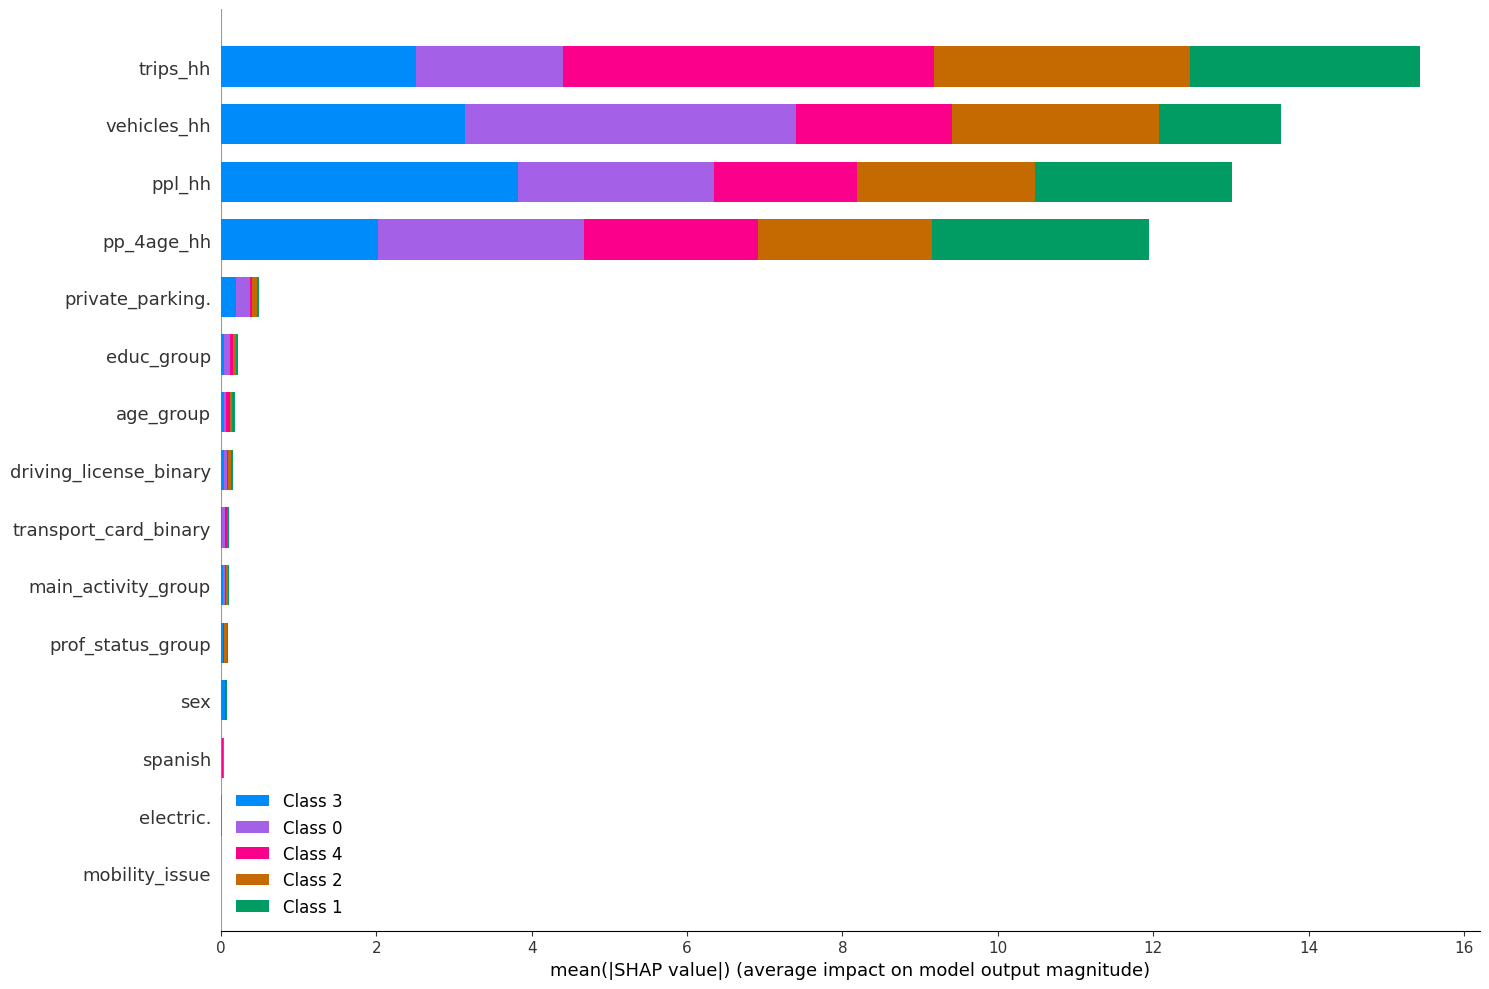

In [13]:
#SHAP explanation
explainer_km = shap.TreeExplainer(clf_km_tuned)
shap_values_km = explainer_km.shap_values(X)
shap.summary_plot(shap_values_km, X, plot_type="bar", plot_size=(15, 10))